### Install dependencies

In [1]:
# %pip install xgboost

### Load dependencies

In [2]:
import pandas as pd
import numpy as np
import xgboost as xgb
import os, time, sys

from datetime import datetime
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score

sys.path.append('../')

from src.functions import *

# Set the local time zone
os.environ['TZ'] = 'America/Montreal'
time.tzset()

gs_uri = 'gs://videotron-ai-bucket/'
dataset_path = gs_uri + 'dataset/'
results_path = gs_uri + 'results/'
figures_path = gs_uri + 'plots/'

### Load data from GCP Bucket

In [3]:
CCT_df, perfo_df = load_dataset(dataset_path)

Dataframe memory usage: 106.62 MB


### Drop tickets that are automatically managed per the system

In [4]:
CCT_df = CCT_df.loc[~CCT_df['Submitter'].str.contains('SYSTEM')]

### Drop columns with to many Nan values

In [5]:
threshold = 0.8 # Drop columns with more than 80% of nan values

print("Dataframe memory usage: %.2f MB" % (CCT_df.memory_usage().sum()/(1024*1024)))

CCT_df = CCT_df.dropna(axis=1, thresh=int(CCT_df.shape[0]*threshold))

Dataframe memory usage: 106.36 MB


### Cast columns to right types

In [6]:
CCT_df = cast_CCT_features(CCT_df)

Converting Submit_Date
Converting closed_date
Dataframe memory usage: 75.28 MB


### Group the data by date and create the label for the prediction
* Ticket cnt is the label

In [7]:
groupby = CCT_df.groupby('Submit_Date_day')

agg_df = pd.DataFrame(groupby['status'].count().reset_index().values, columns=['Submit_Date_day', 'Ticket cnt'])
agg_df['Ticket cnt'] = agg_df['Ticket cnt'].astype(int)
agg_df['Submit_Date_day'] = pd.to_datetime(agg_df['Submit_Date_day'])
agg_df['year-month'] = agg_df['Submit_Date_day'].apply(lambda x: str(x.year) + '-'+ str(x.month))
min_dt = agg_df['Submit_Date_day'] .min()
max_dt = agg_df['Submit_Date_day'] .max()

### Plot some charts for analytics

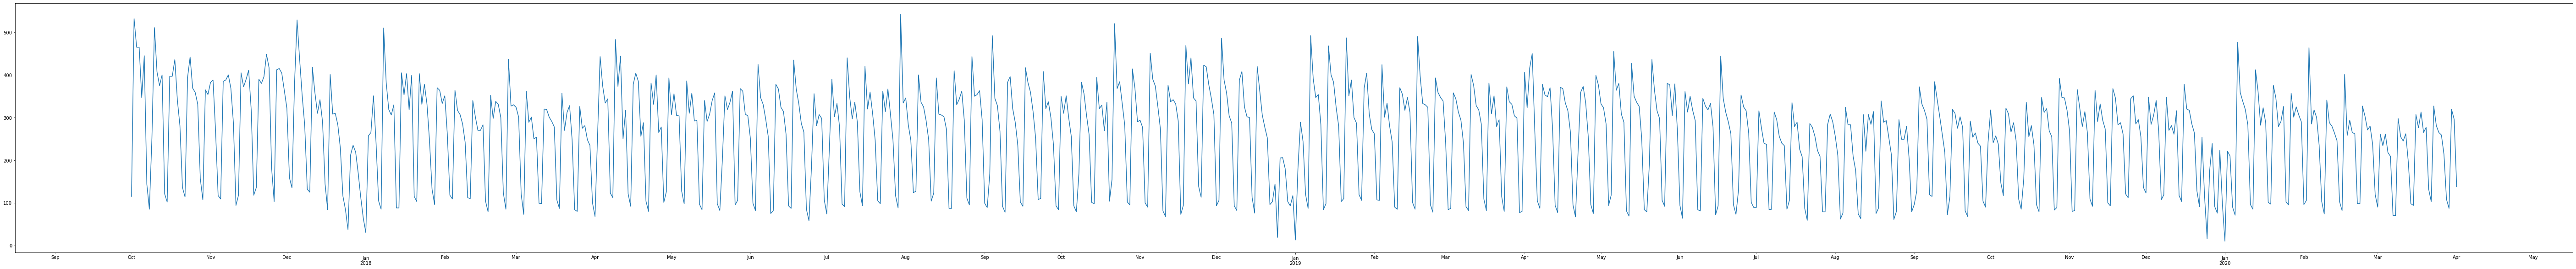

In [8]:
plot_label(agg_df['Submit_Date_day'].values, agg_df['Ticket cnt'].values)

### Feature Engineering for Time Series #1: Date-Related Features

In [9]:
dataset = build_date_related_features(agg_df)

### Feature Engineering for Time Series #2: Event-Related Features
Here is a list of important events that videotron wants to integrate to the machine learning model:
* Black Friday: not a fixed date
* Cyber Monday: not a fixed date (the next monday after a black friday)
* Back to school: not a fixed date. From mid August until mid-september: we chose the last monday of august as a generic date for back to school
* Moving period: from mid-may until mid-july. There is a surge at the end of june. Most of the lease agreement in Quebec start July 1st
* Holidays promotions: from mid-november until the holidays: 2 events: Christmas (December 25th) and first day of the year (January 1st)

In [10]:
dataset = build_event_related_features(dataset)

### Feature Engineering for Time Series #3: Lag Features

We use the ACF (Autocorrelation Function) and PACF (Partial Autocorrelation Function) plots to determine the lag at which the correlation is significant

* ACF: The ACF plot is a measure of the correlation between the time series and the lagged version of itself
* PACF: The PACF plot is a measure of the correlation between the time series with a lagged version of itself but after eliminating the variations already explained by the intervening comparisons

More details on ACF and PACF: https://machinelearningmastery.com/gentle-introduction-autocorrelation-partial-autocorrelation/

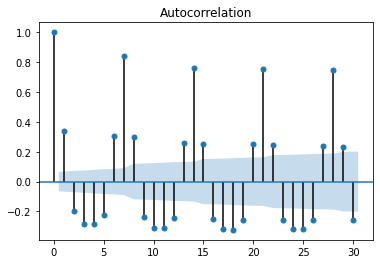

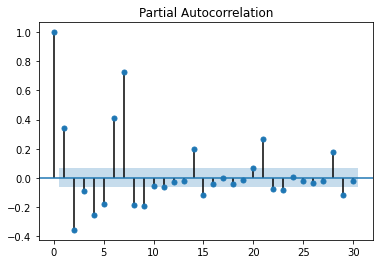

In [11]:
plot_acf(dataset['Ticket cnt'], lags=30)
plot_pacf(dataset['Ticket cnt'], lags=30) 

# Build the lag features
dataset = build_lag_features(dataset, 'Ticket cnt')

### Feature Engineering for Time Series #4: MEP (IT events planning) features

In [12]:
mep_df = build_mep_features(dataset_path)
dataset = dataset.merge(mep_df, how='left', left_on='Submit_Date_day', right_on='mep_date_day').drop(columns=['mep_date_day'])

### Feature Engineering for Time Series #5: performances features for Videotron's call center

In [13]:
# perfo_df = build_perfo_features(dataset_path)
# perfo_df = perfo_df.loc[perfo_df['Date']>=min_dt].reset_index(drop=True).drop(columns=['Date'])
# dataset = pd.concat([dataset, perfo_df], axis=1)

### Feature Engineering #6: Weather related features

In [14]:
# weather_df = build_weather_features(dataset_path, min_dt, max_dt, plot=False)
# dataset = pd.concat([dataset, weather_df], axis=1)

### Feature Engineering #7: STM related features

In [15]:
# TBD

### Feature Engineering #8: Google Trends related features

In [16]:
# trends_df = pd.read_csv(dataset_path + 'keyword_trends_dataset.csv', low_memory=False)
# trends_df['date'] = pd.to_datetime(trends_df['date'].fillna('1900-01-01 00:00:00.000'))
# trends_df = trends_df.loc[trends_df['date']>=min_dt].reset_index(drop=True).drop(columns=['date'])
# kw_list = trends_df.columns.values
# dataset = pd.concat([dataset, trends_df], axis=1)

### Feature Engineering #9: Feature selection
Based on the following article: https://machinelearningmastery.com/feature-selection-time-series-forecasting-python/

In [17]:
df = dataset.drop(columns=['Submit_Date_day', 'year-month'])

scaler = MinMaxScaler()

scaler.fit(df)
df = pd.DataFrame(scaler.transform(df), columns=df.columns.values)

### Pearson correlation: analysis
* Pearson correlation: https://towardsdatascience.com/four-ways-to-quantify-synchrony-between-time-series-data-b99136c4a9c9
* How to interpret Pearson correlation: https://support.minitab.com/en-us/minitab-express/1/help-and-how-to/modeling-statistics/regression/how-to/correlation/interpret-the-results/

Only values with a p-value less or equal than ⍺ (⍺=0.05) and a high pearson-r (above ≈0.40 or below ≈-0.40) score should be kept

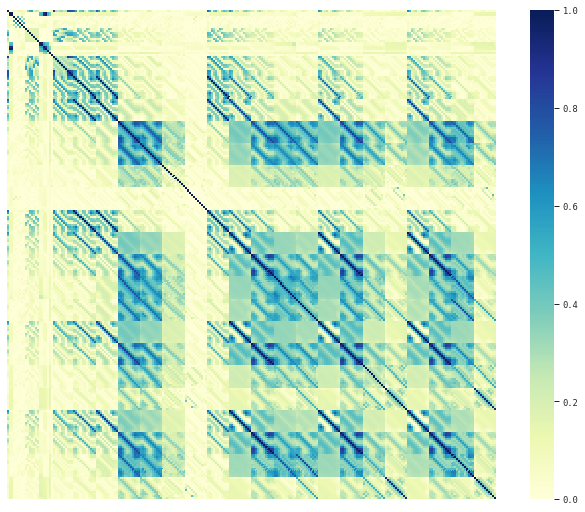

In [18]:
import seaborn as sns

corrmat = df.corr(method='pearson', min_periods=500)

# plot absolute values
corrmat = np.abs(corrmat)
sns.set(context="paper", font="monospace")
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, cmap="YlGnBu", vmin=0, vmax=1,square=True, xticklabels = False, yticklabels = False)

### Display the correlation between the features and the target ticket cnt
Use a rolling window to display the synchrony pattern between the target time serie and the feature time serie

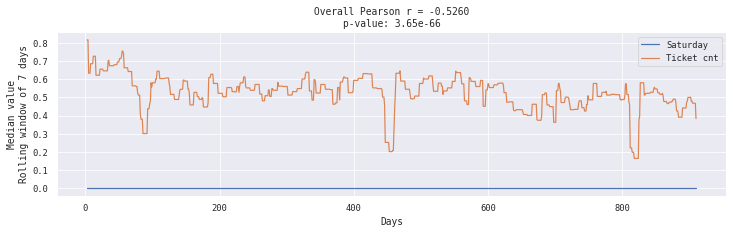

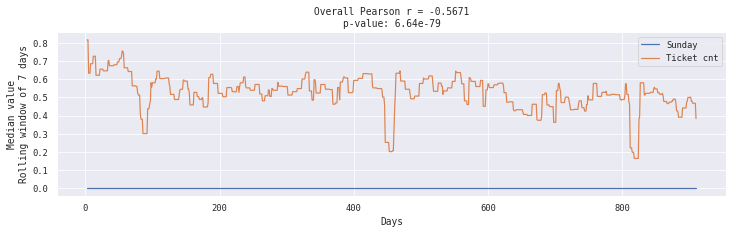

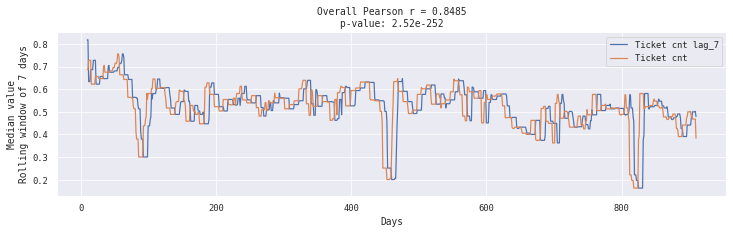

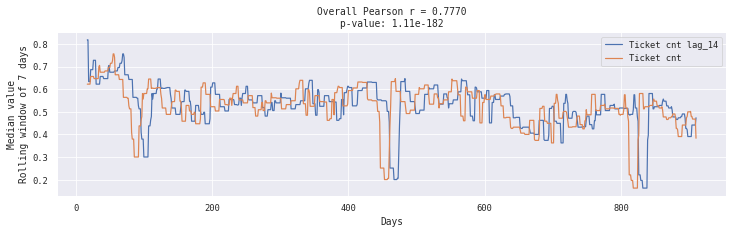

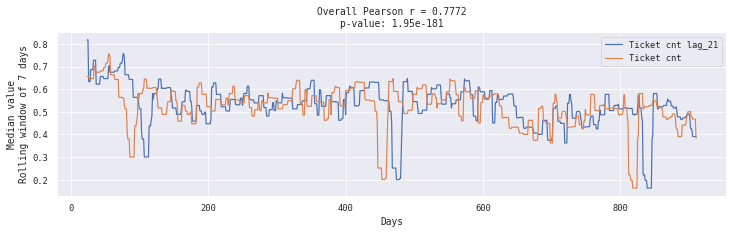

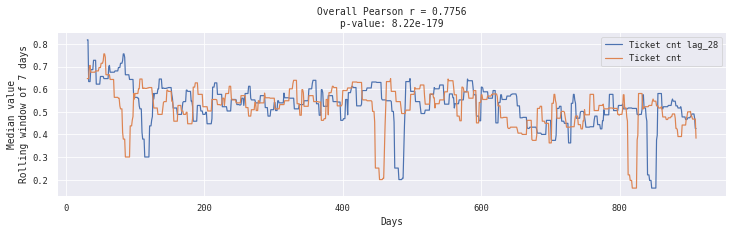

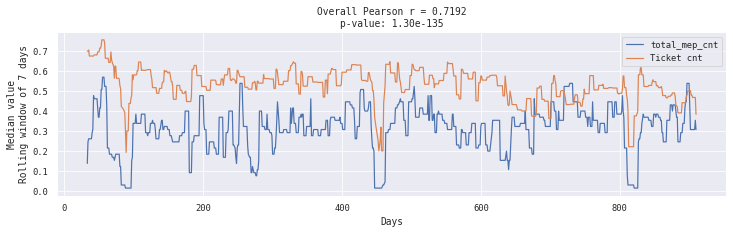

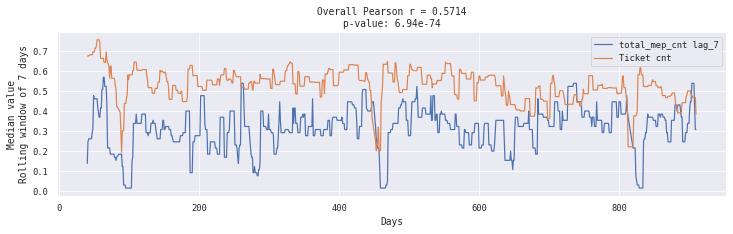

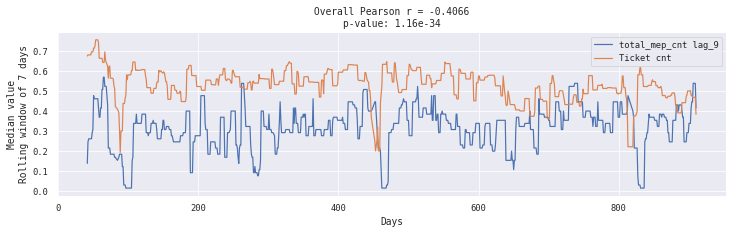

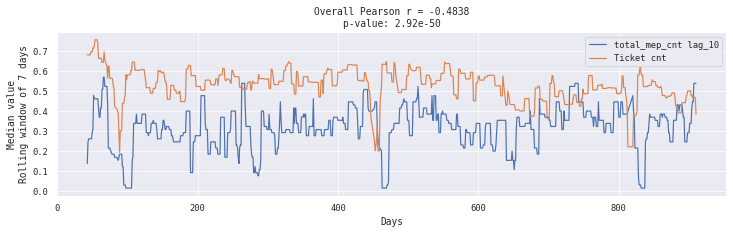

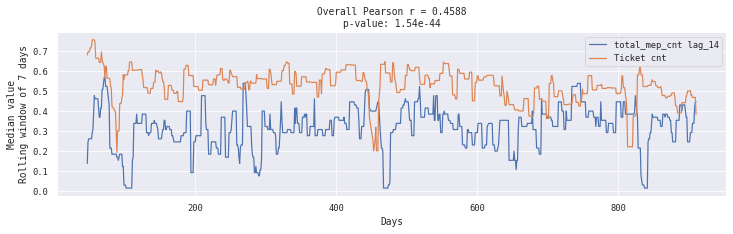

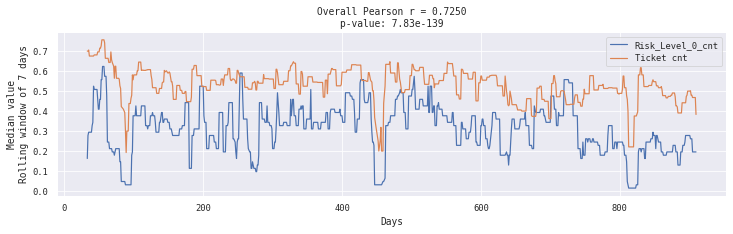

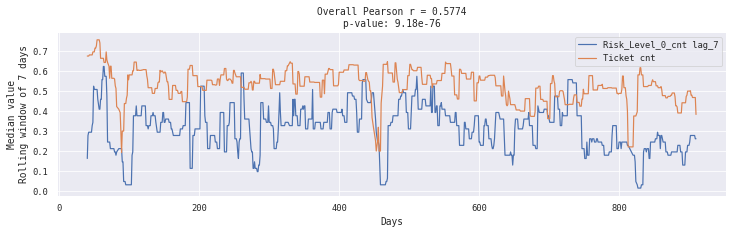

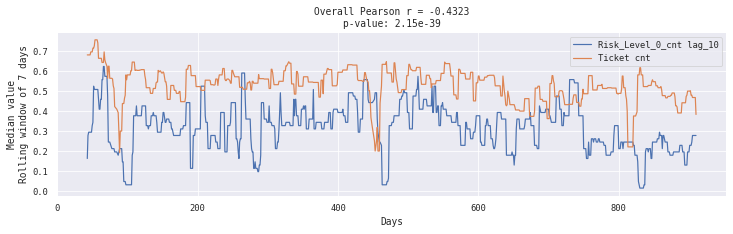

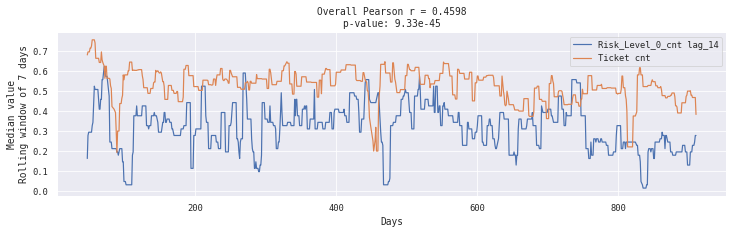

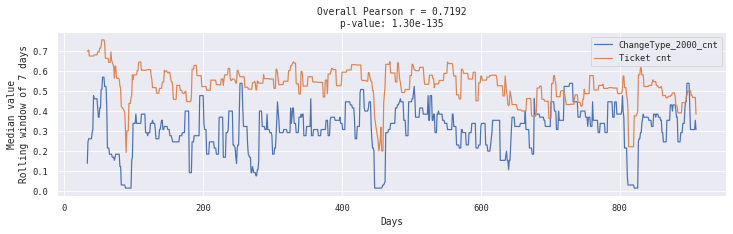

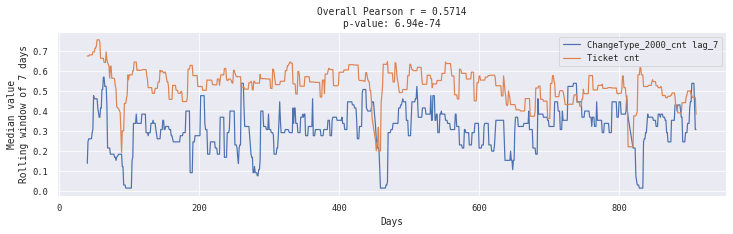

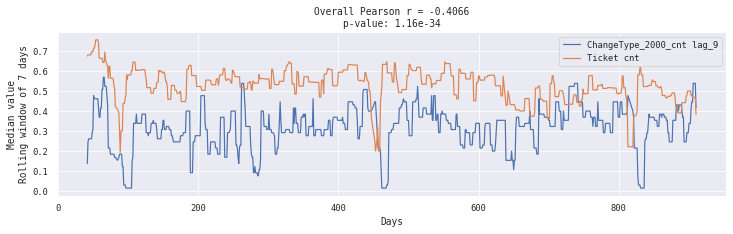

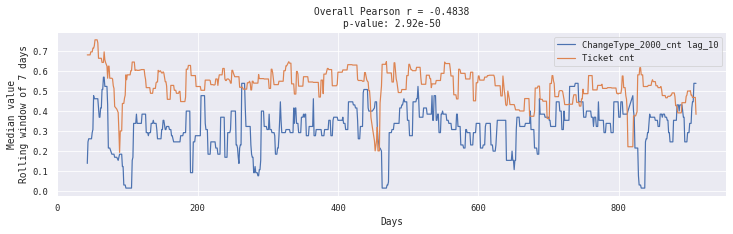

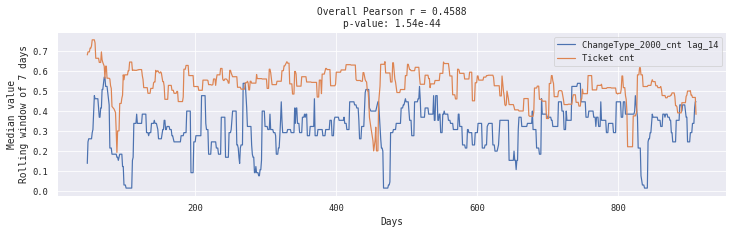

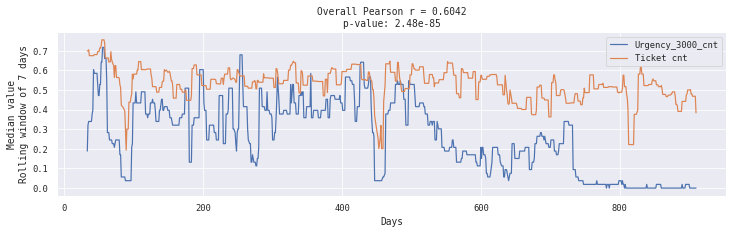

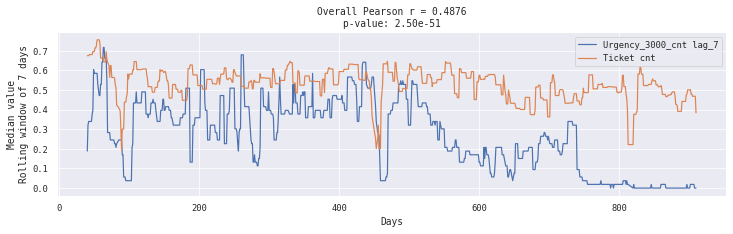

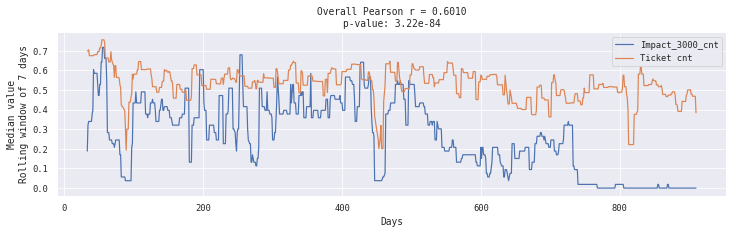

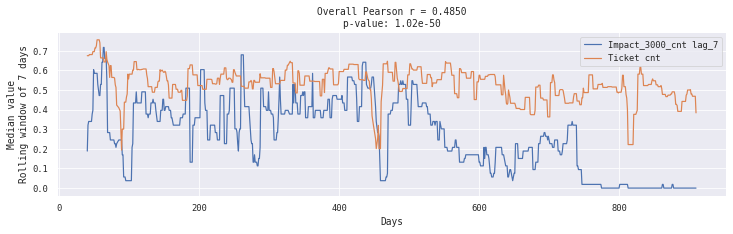

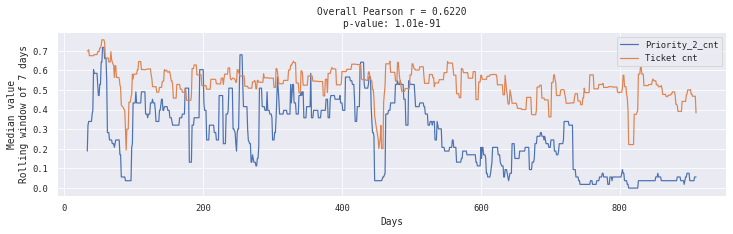

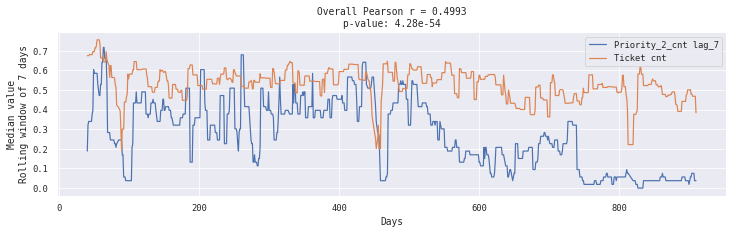

In [19]:
alpha = 0.05
person_r_threshold = 0.40

# Look for correlation between the ticket cnt and the MEP planning
# corr_df = plot_pearson_corr(df, mep_df.iloc[:, 1:].columns.values, plot=True, threshold=person_r_threshold, alpha=alpha)
corr_df = plot_pearson_corr(df, df.drop(columns=['Ticket cnt']).columns.values, plot=True, threshold=person_r_threshold, alpha=alpha)

# Compute the pearson coefficient correlation and display only the most significant features
drop_list = corr_df.loc[~((corr_df['abs_pearson_r'] > person_r_threshold) & (corr_df['p-value'] < alpha)), 'feature']

### Display an horizontal bar chart with the feature that are the most corrolated with the target variable

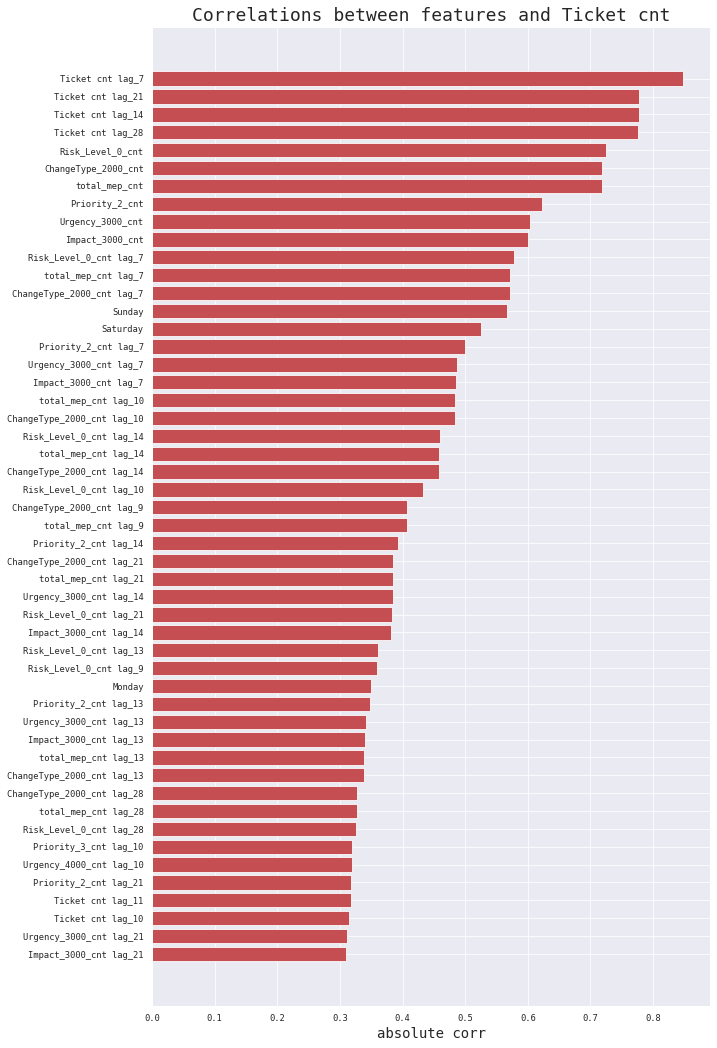

In [20]:
remain_num = 50
width = 0.9

x = corr_df.tail(remain_num)['abs_pearson_r'].values
y = corr_df.tail(remain_num)['feature'].values

fig, ax = plt.subplots(figsize=(10,18))
rects = ax.barh(y, x, color='r')
ax.set_yticks(y)
ax.set_yticklabels(y, rotation='horizontal')
ax.set_xlabel("absolute corr", fontsize = 14)
ax.set_title("Correlations between features and Ticket cnt", fontsize = 18)

plt.show()

### Dump the feature engineered dataset

In [21]:
dataset = dataset.rename(columns={'Submit_Date_day':'date'}).dropna(subset=['date'])
dataset.to_csv(dataset_path + 'videotron_full_dataset.csv', index=False)

## Create a first model to validate the feature engineering

### Day Forward-chaining Nested Cross-Validation
Technic explained here: https://towardsdatascience.com/time-series-nested-cross-validation-76adba623eb9

<img src="https://miro.medium.com/max/1400/1*2-zaRQ-dsv8KWxOlzc8VaA.png" width="70%" height="70%">

### Set the parameters for the model's training

In [22]:
n_folds = 26
n_iter = 100
val_length = 1 # in months
test_length = 3 # in months

xgb_imp_threshold = 0 #0.005
alpha = 0.05
person_r_threshold = 0.20

train_start_dt = dataset['date'].min()

xgb_params = {    
              'objective':'reg:squarederror',
              'random_state': 42,
              'n_jobs': -1
             }

param_dist = {
              'n_estimators': stats.randint(100, 1000),
              'learning_rate': stats.loguniform(0.01, 0.1),
              'subsample': stats.uniform(0.3, 0.7),
              'max_depth': [3, 4, 5, 6, 7, 8, 9],
              'colsample_bytree': stats.uniform(0.5, 0.45),
              'min_child_weight': [1, 2, 3, 4, 5],
              'random_state': [42]
             }

xgb_rg = xgb.XGBRegressor(**xgb_params)
estimators = []
predictions = []

range_ = range(24, n_folds+1)

mse_scores = []
rmse_scores = []
r2_scores =[]

### Run the model training
Apply a feature selection during the model's training

Fold 24:
	* Train set:      from 2017-10-01 to 2019-09-30
	* Validation set: from 2019-10-01 to 2019-10-31
	* Test set:       from 2019-11-01 to 2020-02-01



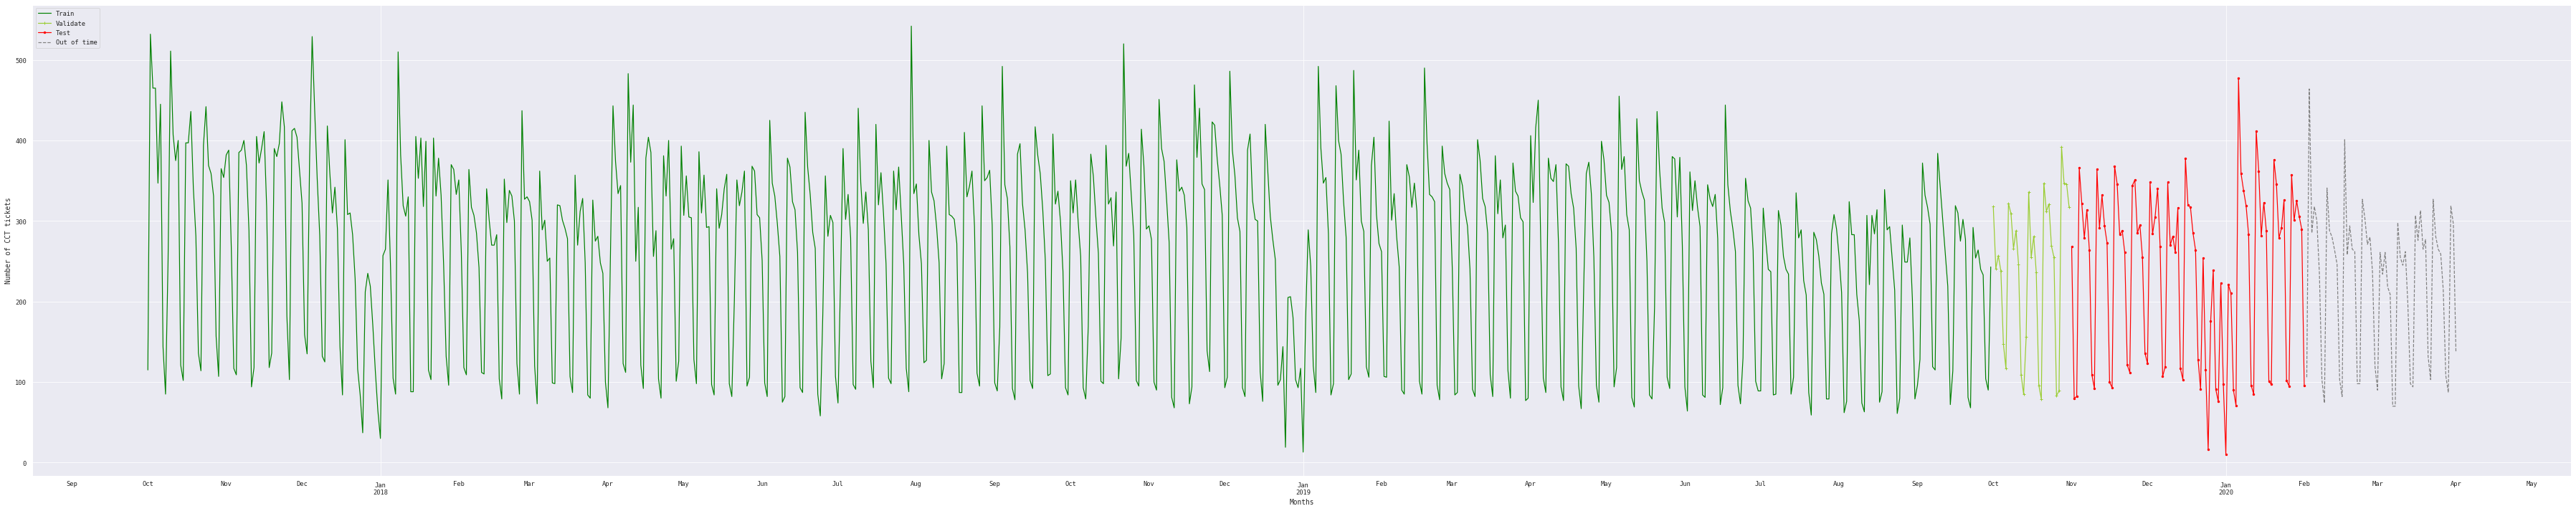

No feature selection. Training the model on 241 features
Fitting 1 folds for each of 100 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  4.7min finished


MSE loop 24: 1468.570305
RMSE loop 24: 38.321930
R2 loop 24: 0.875508
Fold 25:
	* Train set:      from 2017-10-01 to 2019-10-31
	* Validation set: from 2019-11-01 to 2019-11-30
	* Test set:       from 2019-12-01 to 2020-03-01



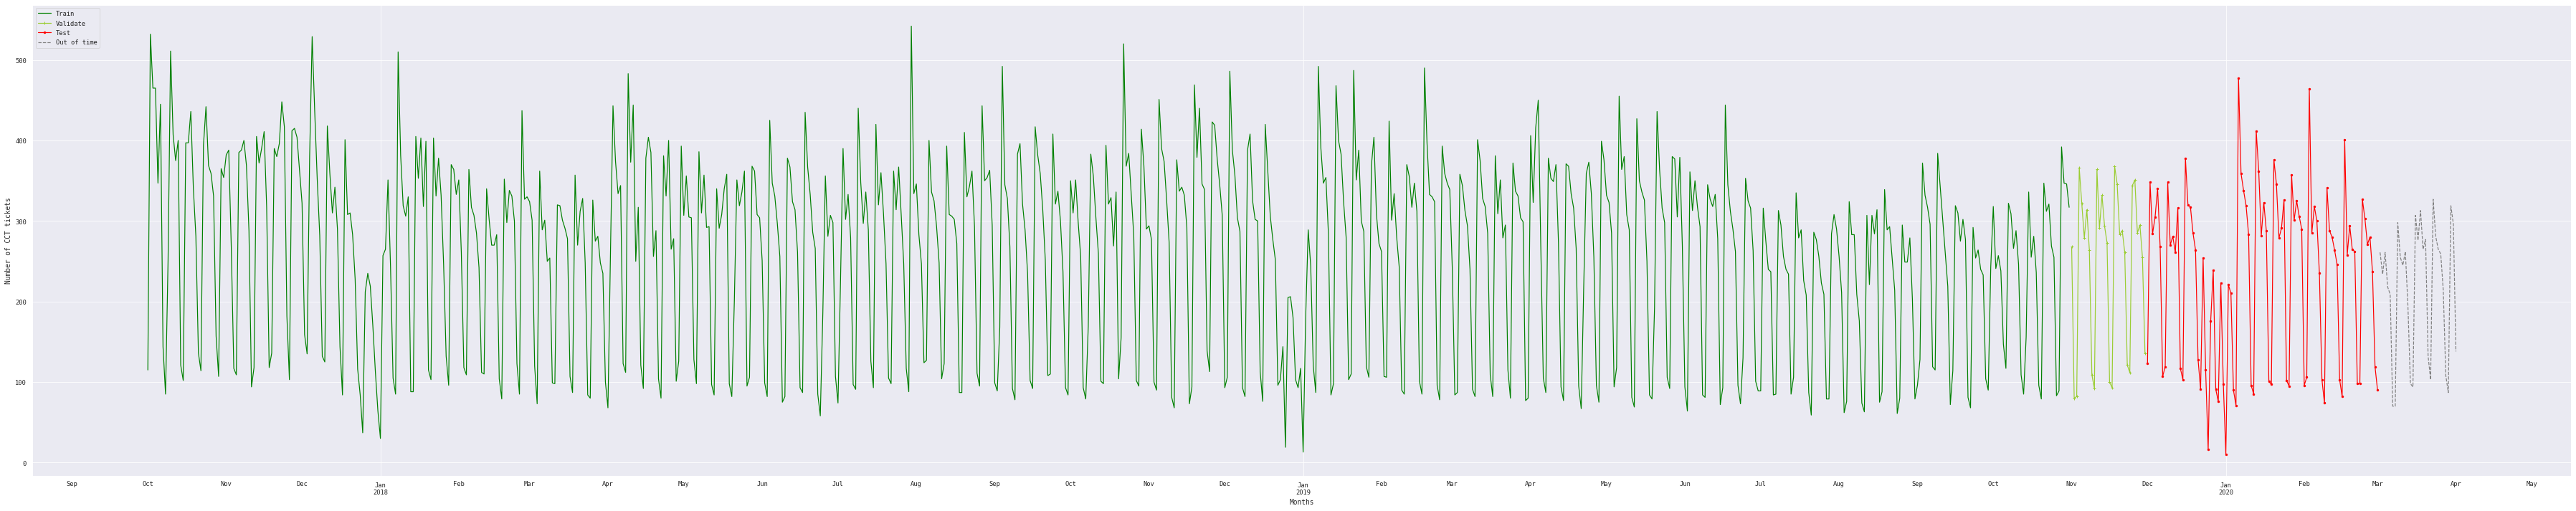

No feature selection. Training the model on 241 features
Fitting 1 folds for each of 100 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  5.2min finished


MSE loop 25: 1666.325540
RMSE loop 25: 40.820651
R2 loop 25: 0.861307
Fold 26:
	* Train set:      from 2017-10-01 to 2019-11-30
	* Validation set: from 2019-12-01 to 2019-12-31
	* Test set:       from 2020-01-01 to 2020-04-01



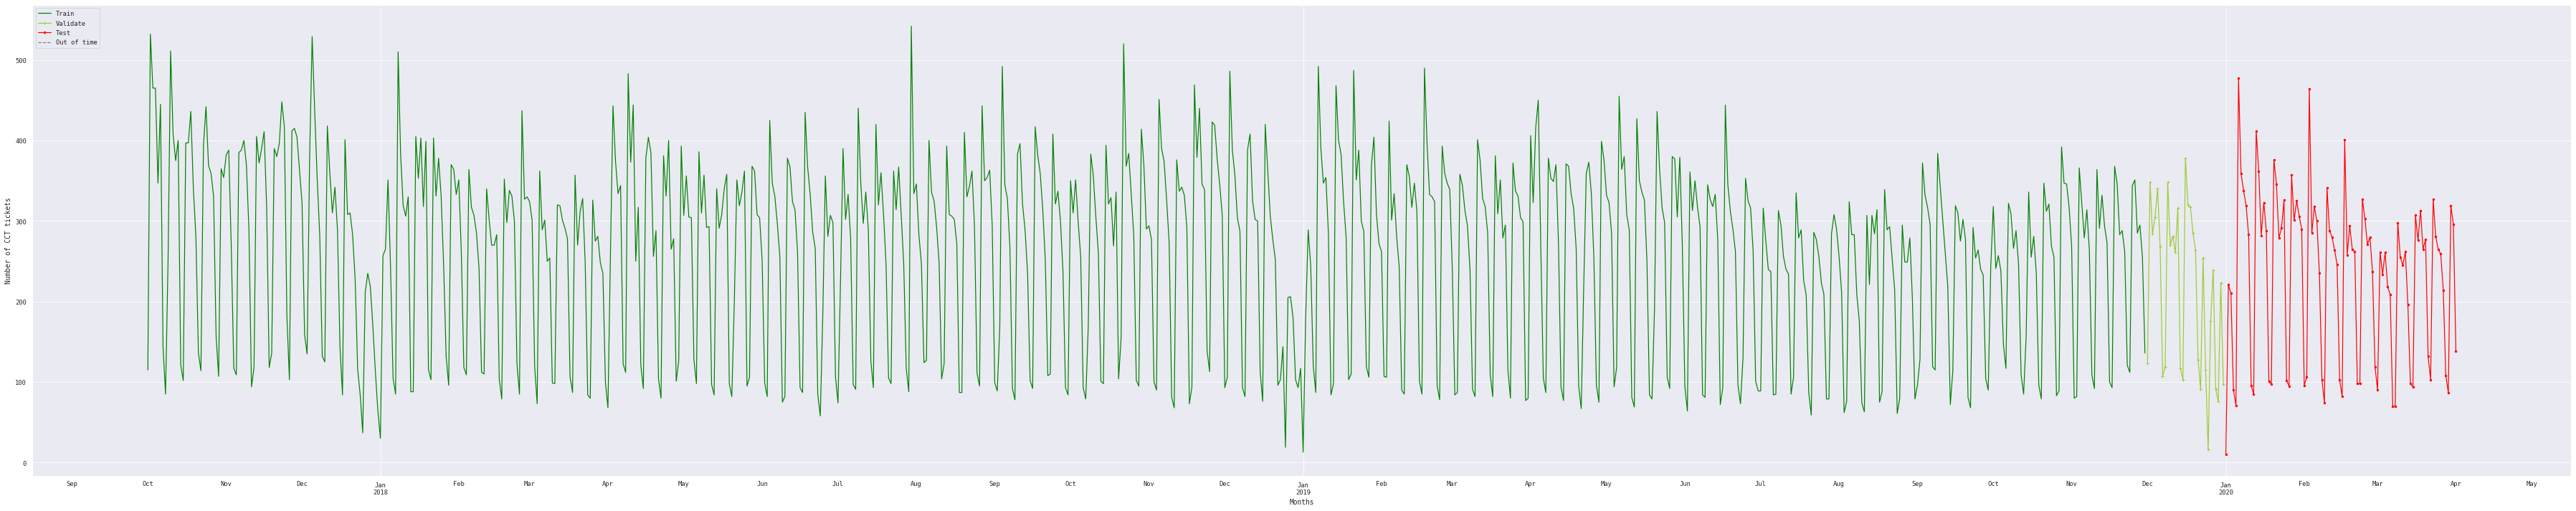

No feature selection. Training the model on 241 features
Fitting 1 folds for each of 100 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  5.7min finished


MSE loop 26: 1258.593016
RMSE loop 26: 35.476655
R2 loop 26: 0.883227


In [23]:
for offset_months in range_:
    index_val = offset_months-1
    
    X_train, X_val, X_test, X_out_of_time, y_train, y_val, y_test, y_out_of_time, labels = get_train_val_test_dataset(dataset, 
                                                                                                              train_start_dt,
                                                                                                              val_length,
                                                                                                              test_length,
                                                                                                              offset_months)
    

    # Standardize the train, validation and test set based on the train data set
    # Not required for XGBoost or tree based algo but mandatory for other classifier
    scaler = MinMaxScaler()
    scaler.fit(X_train)
    
    X_train       = pd.DataFrame(scaler.transform(X_train),       index=X_train.index,       columns=X_train.columns.values)
    X_val         = pd.DataFrame(scaler.transform(X_val),         index=X_val.index,         columns=X_train.columns.values)
    X_test        = pd.DataFrame(scaler.transform(X_test),        index=X_test.index,        columns=X_train.columns.values)
    if X_out_of_time.shape[0] > 0:
        X_out_of_time = pd.DataFrame(scaler.transform(X_out_of_time), index=X_out_of_time.index, columns=X_train.columns.values)
        
    # Plot the train, validation and test set
    if (offset_months <= n_folds):
        plot_train_val_test(dataset['date'], labels, X_train.index, X_val.index, X_test.index, X_out_of_time.index)

    f_list = apply_feature_selection(X_train, feature_selection=False, xgb_imp_threshold=xgb_imp_threshold, person_r_threshold=person_r_threshold)
    
    # Create a new pipeline for a randomized search CV
    regressor = RandomizedSearchCV(xgb_rg, cv=[(X_train[f_list].index,
                                                X_val[f_list].index)],
                                   param_distributions=param_dist, 
                                   n_iter=n_iter, scoring = 'neg_mean_squared_error', 
                                   error_score=0, verbose=3, n_jobs=-1)
    
    # The cross validation will be done only once on the train and validation set
    regressor.fit(X_train[f_list].append(X_val[f_list]), y_train.append(y_val))    
    
    # Get the best estimator
    xgb_rg = regressor.best_estimator_
    
    # Fit a new regressor on the best estimator parameters and evaluate the model
    # The model is fitted on the train & validation dateset then evaluated on the test set
    xgb_rg.fit(X_train[f_list].append(X_val[f_list]), y_train.append(y_val))    
    estimators.append(xgb_rg)
    y_pred = xgb_rg.predict(X_test[f_list])
    predictions.append(y_pred)
    
    mse_scores.append(mean_squared_error(y_test, y_pred))
    rmse_scores.append(mean_squared_error(y_test, y_pred, squared=False))
    r2_scores.append(r2_score(y_test, y_pred))
    print('MSE loop %d: %f' % (offset_months, mse_scores[-1]))
    print('RMSE loop %d: %f' % (offset_months, rmse_scores[-1]))
    print('R2 loop %d: %f' % (offset_months, r2_scores[-1]))

### Retrieve the final model and the final predictions from the nested cross-validation 

In [24]:
xgb_rg = estimators[-1]
y_pred = predictions[-1]

### Display feature importance
The most important features are showed below

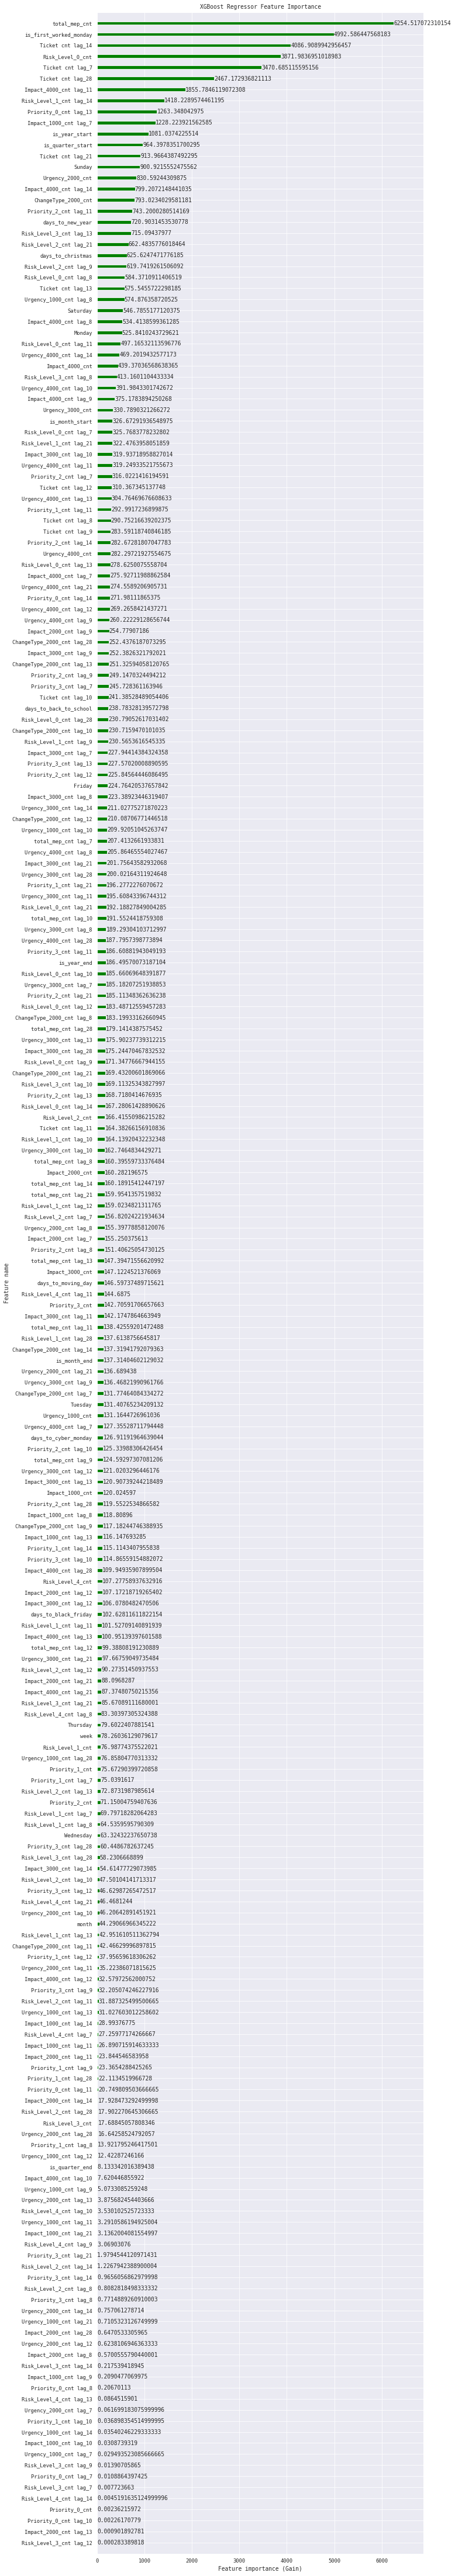

In [25]:
nb_features = len(xgb_rg.feature_importances_)


fig, ax = plt.subplots(figsize=(10, int(nb_features/3)))

xgb.plot_importance(xgb_rg, importance_type='gain', height=0.3, ax=ax,
                    title='XGBoost Regressor Feature Importance', color='green',
                    ylabel='Feature name', xlabel='Feature importance (Gain)')

### Compute the regression's metrics
* RMSE
* MSE
* R<sup>2</sup>

In [26]:
mse_score = np.mean(mse_scores) 
rmse_score = np.mean(rmse_scores) 
r2 = np.mean(r2_scores) 

print('MSE score on nested cross-validation: %f' % mse_score)
print('RMSE score on nested cross-validation: %f' % rmse_score)
print('R2 score on nested cross-validation: %f' % r2)

print('MSE score of the last model: %f' % mse_scores[-1])
print('RMSE score of the last model: %f' % rmse_scores[-1])
print('R2 score of the last model: %f' % r2_scores[-1])

# We should keep only the last model trained during the nest cross-validation. Save the results of this model
results={'Datetime': dt.datetime.now().strftime('%Y-%m-%d %H:%M'),
         'MSE': mse_score,
         'RMSE': rmse_score,
         'R2': r2,
         'model': 'XGBoost Regressor',
         'comments': 'XGBoost Regressor with internal + MEP features and a lag of 1 week'}

MSE score on nested cross-validation: 1464.496287
RMSE score on nested cross-validation: 38.206412
R2 score on nested cross-validation: 0.873347
MSE score of the last model: 1258.593016
RMSE score of the last model: 35.476655
R2 score of the last model: 0.883227


### Append the metrics to the results file

In [27]:
results_df = export_results(results, path=results_path)
results_df

Datetime          MSE       RMSE  \
0   2020-04-10 22:01  1833.413043  42.818373   
1   2020-04-11 19:59  2064.065217  45.431985   
2   2020-04-11 20:27  2613.383964  49.848779   
3   2020-04-11 20:35  2680.313715  50.208959   
4   2020-04-11 16:37  1496.218578  38.680985   
5   2020-04-11 16:49  1652.826087  40.654964   
6   2020-04-11 16:56  2094.255837  45.763040   
7   2020-04-11 17:03  1597.865593  39.973311   
8   2020-04-11 17:06  1704.935782  41.290868   
9   2020-04-11 17:15  1697.559639  41.201452   
10  2020-04-11 17:22  1895.101795  43.532767   
11  2020-04-11 17:36  1477.235757  38.434825   
12  2020-04-11 18:55  1739.289609  41.704791   
13  2020-04-11 19:01  1484.305703  38.526688   
14  2020-04-11 19:24  1611.996497  40.149676   
15  2020-04-12 17:06  3306.060793  57.498355   
16  2020-04-12 17:10  1439.704700  37.943441   
17  2020-04-12 17:13  2848.298571  53.369454   
18  2020-04-12 17:16  1900.597128  43.595838   
19  2020-04-13 20:29  1971.718129  44.404033   
20  2020-04-13 23:19  2638.146456  50.360093   
21  2020-04-14 21:42    62.403156   1.549233   
22  2020-04-14 22:27    81.869892   1.774498   
23  2020-04-14 22:52  2828.282644  51.581294   
24  2020-04-19 13:53  2024.590815  44.995453   
25  2020-04-19 14:28  3056.879912  52.862046   
26  2020-04-19 16:06  2936.721821  53.275284   
27  2020-04-19 16:10  1734.681704  41.649510   
28  2020-04-19 16:25  1734.681704  41.649510   
29  2020-04-19 16:32  1774.091571  42.119966   
30  2020-04-19 16:42  5503.468776  74.185368   
31  2020-04-19 16:52  1974.637841  44.436897   
32  2020-04-19 17:19  2077.594642  45.580639   
33  2020-04-19 17:34  2749.845757  52.341568   
34  2020-04-19 18:34  2600.257666  50.738398   
35  2020-04-19 18:38  2253.892925  47.335116   
36  2020-04-19 18:52  1831.785046  42.736947   
37  2020-04-20 21:10  1531.009923  39.055217   
38  2020-04-25 16:13  1476.577419  38.402379   
39  2020-04-25 16:39  1482.085657  38.492461   
40  2020-04-25 16:52  1664.023960  40.588153   
41  2020-04-25 17:08  1481.608315  38.447129   
42  2020-04-26 00:17  1458.135934  38.112265   
43  2020-04-26 12:06  1555.478934  39.392103   
44  2020-04-26 14:58  1438.957537  37.830484   
45  2020-04-26 15:22  1550.078863  39.347361   
46  2020-04-29 18:20  1308.541224  36.153625   
47  2020-04-30 12:27  1656.908143  40.458300   
48  2020-04-30 15:28  1479.951758  38.406382   
49  2020-04-30 21:24  1374.105375  37.012012   
50  2020-04-30 22:17  1374.033917  36.976195   
51  2020-05-01 09:24  1494.503999  38.287845   
52  2020-05-06 20:15  1464.496287  38.206412   

                                       R2              model  \
0                      0.8482962286088432  XGBoost Regressor   
1                      0.8457697421373789  XGBoost Regressor   
2                      0.7997670403599368  XGBoost Regressor   
3                      0.7954886549294755  XGBoost Regressor   
4                      0.8882001522599139  XGBoost Regressor   
5                      0.8764981884072685  XGBoost Regressor   
6                      0.8435138506650197  XGBoost Regressor   
7                      0.8806049245179179  XGBoost Regressor   
8                      0.8726044685252347  XGBoost Regressor   
9                      0.8731556257375758  XGBoost Regressor   
10                     0.8583949595862111  XGBoost Regressor   
11                     0.8896185790190951  XGBoost Regressor   
12                     0.8700374955911636  XGBoost Regressor   
13                     0.8890903013260967  XGBoost Regressor   
14                     0.8795490407337635  XGBoost Regressor   
15                     0.7529658441518334  XGBoost Regressor   
16                     0.8924229596763018  XGBoost Regressor   
17                     0.7871705702780692  XGBoost Regressor   
18                     0.8579843394918063  XGBoost Regressor   
19                     0.8526700644674126  XGBoost Regressor   
20  <function r2_score at 0x7f2df84808c0>  XGBoost Regressor   
21  <functi

### Plot the predicted volume of tickets vs the observation
The prediction is made on the last test dataset

Fold 26:
	* Train set:      from 2017-10-01 to 2019-11-30
	* Validation set: from 2019-12-01 to 2019-12-31
	* Test set:       from 2020-01-01 to 2020-04-01



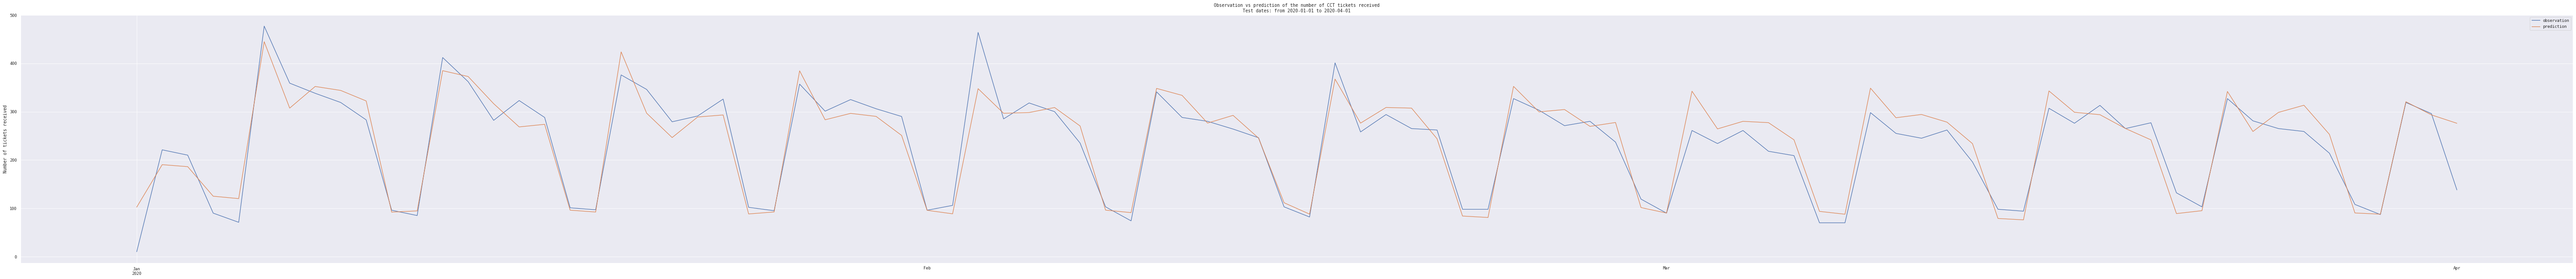

In [28]:
_, _, _, test_start_dt, test_end_dt = compute_train_val_test_dates(train_start_dt, val_length, test_length, n_folds)

plot_predictions_vs_observations(dataset.loc[X_test.index, 'date'].values, y_test, y_pred, test_start_dt, test_end_dt)

### Save the predictions on 3 months of test for ROI computation

In [29]:
dt_str = datetime.now().strftime('%Y%m%d%H%M')

output_df = pd.DataFrame(dataset.loc[X_test.index, 'date'].values, columns=['date'])
output_df['ticket cnt obs'] = y_test
output_df['ticket cnt pred'] = y_pred

output_df.to_csv(results_path + f'ticket_count_prediction_{dt_str}.csv', index=False)